# **Projet : Full Waveform Inversion (FWI)**


# Introduction : Imagerie sismique et inversion complète de forme d’onde (FWI)

L’imagerie sismique est une technique essentielle pour analyser les structures internes de la Terre. Elle est utilisée dans de nombreux domaines comme :
- la **géologie**,
- l’**exploration pétrolière et gazière**,
- le **stockage de CO₂**,
- ou même l’**imagerie médicale** (ultrasons).

Parmi les méthodes d’imagerie avancées, la **Full Waveform Inversion (FWI)** permet d’estimer avec une grande précision la **carte de vitesse du sous-sol** à partir des **signaux sismiques** enregistrés en surface.

---

# Formulation physique

Le comportement des ondes sismiques dans un milieu est régi par l’**équation d’onde acoustique** :

\\[
\nabla^2 p(x, z, t) - \frac{1}{c(x, z)^2} \frac{\partial^2 p(x, z, t)}{\partial t^2} = s(x, z, t)
\\]

où :

- \( p(x, z, t) \) : champ d’onde sismique (wavefield),
- \( c(x, z) \) : carte de vitesse du milieu (velocity map),
- \( s(x, z, t) \) : source sismique (explosif, marteau, air gun...).

En pratique, on ne peut mesurer \( p \) qu’à la surface, via des géophones, sous la forme :

\\[
p(x = g, z = 0, t)
\\]

---

# Objectif

Le problème d’inversion consiste à **reconstruire la carte de vitesse** \( c(x, z) \) à partir des mesures de surface :

\\[
\boxed{p(g, t) \longrightarrow c(x, z)}
\\]

Ce projet vise à résoudre ce problème via des techniques d’**apprentissage profond**, en entraînant un réseau de type **U-Net avec attention** sur un jeu de données simulées proposé dans le cadre de la compétition *“Yale/UNC-CH - Geophysical Waveform Inversion”*.


# Chargement des bibliothèques

Dans cette cellule, nous importons toutes les bibliothèques nécessaires pour le traitement des données, l'entraînement du modèle et la visualisation des résultats.

- `numpy`, `pandas` : pour la manipulation des données.
- `torch`, `torch.nn`, `torch.utils.data` : pour construire et entraîner les modèles de deep learning avec PyTorch.
- `matplotlib.pyplot` : pour tracer les courbes et visualiser les prédictions.
- `sklearn.metrics` : pour calculer les métriques de performance (MSE, MAE).
- `torch.optim.lr_scheduler` : pour ajuster dynamiquement le taux d’apprentissage lors de l'entraînement.


In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch.optim.lr_scheduler as lr_scheduler

# Configuration des hyperparamètres

Cette cellule définit les paramètres essentiels pour l'entraînement du modèle :

- `batch_size` : taille des lots d’échantillons utilisés à chaque itération.
- `learning_rate` : taux d’apprentissage utilisé par l’optimiseur.
- `epochs` : nombre maximal d’époques pour l’entraînement.
- `device` : choix automatique entre GPU (`cuda`) et CPU selon la machine.
- `patience` : nombre d’époques sans amélioration avant d’activer l’**early stopping**.
- `validation_split` : proportion des données réservée à la validation.
- `weight_decay` : régularisation L2 pour éviter le surapprentissage.
- `gradient_clip` : limite la norme des gradients pour stabiliser l’entraînement.

In [6]:
# Configuration avancée
config = {
    'batch_size': 6,
    'learning_rate': 5e-5,  # Learning rate plus faible
    'epochs': 100,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'patience': 15,
    'validation_split': 0.2,
    'weight_decay': 1e-5,
    'gradient_clip': 0.5
}


# Chargement des données sismiques

Dans cette section, nous parcourons le répertoire contenant les fichiers `.npy` fournis par la compétition. On distingue deux types de fichiers :

- `data` : les signaux sismiques bruts (5 canaux × 70 × 1000),
- `model` : les cartes de vitesse du sous-sol associées (70 × 1000).

Les fichiers sont triés pour assurer une correspondance entre les entrées et les sorties, puis chargés et concaténés en matrices `x_data` et `y_data`, respectivement.

Cette étape constitue la **base d'apprentissage supervisé** : chaque exemple est une paire (entrée : données sismiques, sortie : carte de vitesse).


In [7]:
# 1. Chargement des données
base_dir = '/kaggle/input/waveform-inversion/train_samples'
seismic_files = []
velocity_files = []

for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.endswith('.npy'):
            full_path = os.path.join(root, f)
            if 'data' in full_path:
                seismic_files.append(full_path)
            elif 'model' in full_path:
                velocity_files.append(full_path)

seismic_files = sorted(seismic_files)
velocity_files = sorted(velocity_files)
print(f"Nombre de fichiers data: {len(seismic_files)}")
print(f"Nombre de fichiers model: {len(velocity_files)}")

x_data = np.concatenate([np.load(f) for f in seismic_files], axis=0)
y_data = np.concatenate([np.load(f) for f in velocity_files], axis=0)

Nombre de fichiers data: 12
Nombre de fichiers model: 12


Résultats du chargement des données

Nous avons chargé les fichiers `.npy` à partir du dossier fourni. Le résultat du chargement donne :

- **Nombre de fichiers `data` (signaux sismiques)** : 12  
- **Nombre de fichiers `model` (cartes de vitesses du sous-sol)** : 12  

Interprétation

Chaque fichier `data` contient une série de volumes sismiques 5 canaux × 70 × 1000 simulés pour un scénario donné, tandis que chaque fichier `model` contient la carte de vitesse correspondante.

> Le fait d’avoir **autant de fichiers `data` que de fichiers `model`** signifie que nous avons une correspondance parfaite entre les entrées et les cibles. Cela garantit la **cohérence de l'apprentissage supervisé**, où chaque exemple d'entrée dispose bien de son étiquette.

---



# Prétraitement : Redimensionnement spatial

Les données initiales sont de taille 70 × 1000. Afin de réduire la complexité computationnelle tout en conservant les structures importantes, nous appliquons un **downsampling bilinéaire** vers une taille uniforme de **70 × 70**.

Ce redimensionnement est effectué via `torch.nn.functional.interpolate`, en manipulant les dimensions pour respecter l’ordre (batch, canal, hauteur, largeur). Ce format est requis pour les convolutions ultérieures.

Ce prétraitement permet :
- d’uniformiser la taille des entrées,
- d’accélérer l’apprentissage,
- et de réduire la consommation mémoire GPU.


In [8]:
# 2. Préprocessing avancé
def downsample_to_70(arr):
    tensor = torch.tensor(arr, dtype=torch.float32)
    tensor = tensor.permute(0,1,3,2)
    tensor = F.interpolate(tensor, size=(70,70), mode='bilinear', align_corners=False)
    tensor = tensor.permute(0,1,3,2)
    return tensor.numpy()

x_data = downsample_to_70(x_data)

# Normalisation robuste des données

Afin de stabiliser et accélérer l’apprentissage, une **normalisation robuste** est appliquée aux données.

- **Entrées (`x_data`)** : normalisation **canal par canal** avec un **clipping aux percentiles extrêmes** (1% et 99%) pour atténuer l’influence des valeurs aberrantes. Cela garantit une mise à l’échelle centrée autour de 0 avec une variance unitaire.

- **Cibles (`y_data`)** : normalisation **globale** selon la moyenne et l’écart-type. Ces paramètres (`y_mean`, `y_std`) sont sauvegardés pour permettre une **dénormalisation lors de l’évaluation**.

Ce traitement permet une convergence plus rapide du modèle, en supprimant les biais d’échelle entre les différentes cartes.


In [9]:
# Normalisation robuste avec clipping
def robust_normalize(data, clip_percentile=1):
    """Normalisation robuste avec clipping des outliers"""
    lower = np.percentile(data, clip_percentile)
    upper = np.percentile(data, 100 - clip_percentile)
    data = np.clip(data, lower, upper)
    return (data - np.mean(data)) / (np.std(data) + 1e-8)

# Normalisation par canal pour x_data
for i in range(x_data.shape[1]):
    x_data[:,i,:,:] = robust_normalize(x_data[:,i,:,:])

# Normalisation globale pour y_data avec sauvegarde des paramètres
y_mean, y_std = np.mean(y_data), np.std(y_data)
y_data_normalized = robust_normalize(y_data)

print(f"Forme X après preprocessing: {x_data.shape}")
print(f"Forme Y après preprocessing: {y_data_normalized.shape}")
print(f"Paramètres Y - Mean: {y_mean:.4f}, Std: {y_std:.4f}")

Forme X après preprocessing: (6000, 5, 70, 70)
Forme Y après preprocessing: (6000, 1, 70, 70)
Paramètres Y - Mean: 2849.9612, Std: 776.2546


Dimensions après prétraitement

Après concaténation, redimensionnement et normalisation :

- `x_data` (entrées sismiques) : `(6000, 5, 70, 70)`
- `y_data_normalized` (cibles - vitesses du sous-sol) : `(6000, 1, 70, 70)`
- Paramètres de normalisation de `y_data` :
  - **Moyenne (mean)** : 2849.96 m/s
  - **Écart-type (std)** : 776.25 m/s

 donc
 
- **6000 exemples** sont disponibles pour l'entraînement et la validation, provenant de 12 fichiers (soit 500 exemples par fichier).
- Chaque entrée est un volume sismique 2D : 5 canaux, chacun de taille 70×70 après redimensionnement.
- Chaque sortie est une carte de vitesse du sous-sol 70×70 associée à cette entrée.
- La **normalisation robuste** a permis de stabiliser les données en réduisant l'influence des valeurs extrêmes, ce qui est particulièrement important pour l'apprentissage profond.

Ces dimensions sont désormais adaptées à l’architecture U-Net utilisée plus loin.

---

# Dataset personnalisé avec augmentation géophysique

Afin d’améliorer la **généralisation** du modèle, nous définissons une classe `AdvancedWaveformDataset` qui :

- Convertit les tableaux NumPy en tenseurs PyTorch (`x`, `y`) ;
- Applique des **augmentations réalistes** durant l'entraînement pour simuler des variabilités naturelles dans les mesures sismiques :
  - **Ajout de bruit aléatoire** (mimant des erreurs d'acquisition) ;
  - **Flip horizontal/vertical** (simulant des inversions de polarité ou de symétrie du sous-sol).

Ces transformations sont appliquées de façon **probabiliste** uniquement lors de l’apprentissage, afin de renforcer la robustesse sans dégrader la validation.


In [10]:
# 3. Dataset avec augmentation sophistiquée
class AdvancedWaveformDataset(Dataset):
    def __init__(self, x, y, augment=False):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.augment = augment
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        
        if self.augment and torch.rand(1) > 0.5:
            # Augmentation géophysique
            if torch.rand(1) > 0.7:  # Ajout de bruit réaliste
                noise_level = torch.rand(1) * 0.05 + 0.01
                x = x + torch.randn_like(x) * noise_level
            
            if torch.rand(1) > 0.7:  # Rotation légère
                angle = (torch.rand(1) - 0.5) * 10  # ±5 degrés
                # Rotation simple par flip horizontal/vertical
                if torch.rand(1) > 0.5:
                    x = torch.flip(x, [1])
                    y = torch.flip(y, [1])
        
        return x, y

# Modèle U-Net amélioré pour l’inversion sismique

Nous implémentons une architecture **U-Net** adaptée à l’inversion de formes d’ondes sismiques. Ce réseau de neurones convolutif est spécialement conçu pour apprendre une **relation directe entre les signaux sismiques (entrée)** et la **carte de vitesse du sous-sol (sortie)**.

Les principales caractéristiques de ce modèle sont :

-  **Encodeur** : une série de blocs `DoubleConv` + `MaxPooling` pour extraire des caractéristiques hiérarchiques.
-  **Decodeur** : des blocs de `UpSampling` qui permettent de reconstruire la sortie tout en fusionnant les caractéristiques locales et globales via des **connexions de saut** (skip connections).
-  **Modules d'attention** :
      - `ChannelAttention` : sélectionne les canaux d'information pertinents.
      - `SpatialAttention` : met en évidence les régions spatiales importantes.
-  **Sortie finale** : un tenseur 1 canal de taille 70×70 représentant les vitesses sismiques prédites.

Ce U-Net est donc enrichi par des mécanismes d’attention qui **renforcent sa capacité à focaliser l’apprentissage** sur les zones et fréquences informatives, cruciales pour l’interprétation sismique.


In [11]:

# 4. Architecture U-Net avancée pour inversion sismique
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Ajustement de taille si nécessaire
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(x_cat))
        return x * attention

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SeismicUNet(nn.Module):
    def __init__(self, n_channels=5, n_classes=1, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        # Attention modules
        self.channel_att = ChannelAttention(1024 // factor)
        self.spatial_att = SpatialAttention()
        
        # Decoder
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        
        # Output layer avec régularisation
        self.outc = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.1),
            nn.Conv2d(32, n_classes, kernel_size=1)
        )

    def forward(self, x):
        x1 = self.inc(x)      # 64 channels
        x2 = self.down1(x1)   # 128 channels, 35x35
        x3 = self.down2(x2)   # 256 channels, 17x17
        x4 = self.down3(x3)   # 512 channels, 8x8
        x5 = self.down4(x4)   # 1024 channels, 4x4
        
        # Attention au niveau du bottleneck
        x5 = self.channel_att(x5)
        x5 = self.spatial_att(x5)
        
        # Decoder avec connexions résiduelles
        x = self.up1(x5, x4)  # 512 channels, 8x8
        x = self.up2(x, x3)   # 256 channels, 17x17
        x = self.up3(x, x2)   # 128 channels, 35x35
        x = self.up4(x, x1)   # 64 channels, 70x70
        
        logits = self.outc(x)  # 1 channel, 70x70
        return logits

# Fonction de perte géophysique combinée

Pour guider efficacement l’apprentissage, nous définissons une fonction de perte personnalisée `GeophysicsLoss` qui combine plusieurs composantes complémentaires :

- **MSE (Mean Squared Error)** : pénalise fortement les grandes erreurs.
- **L1 Loss** : favorise la conservation des contrastes et est moins sensible aux outliers.
- **SSIM (Structural Similarity Index)** : mesure la similarité de structure entre la prédiction et la vérité, utile pour les images de type "carte de vitesse".
- **Gradient Loss** : préserve les **discontinuités géologiques**, en alignant les dérivées spatiales.

Chaque composante est pondérée via des coefficients (`mse_weight`, `l1_weight`, etc.), permettant de donner plus d’importance à certaines propriétés du sous-sol à reconstruire.

La fonction retourne à la fois la perte totale (à minimiser) et un dictionnaire de valeurs individuelles pour le suivi pendant l'entraînement.


In [12]:

# 5. Fonction de perte sophistiquée
class GeophysicsLoss(nn.Module):
    def __init__(self, mse_weight=0.4, l1_weight=0.3, ssim_weight=0.2, grad_weight=0.1):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.mse_weight = mse_weight
        self.l1_weight = l1_weight
        self.ssim_weight = ssim_weight
        self.grad_weight = grad_weight
    
    def ssim_loss(self, pred, target):
        """SSIM loss pour préserver les structures"""
        mu1 = F.avg_pool2d(pred, 3, 1, 1)
        mu2 = F.avg_pool2d(target, 3, 1, 1)
        
        mu1_sq = mu1 * mu1
        mu2_sq = mu2 * mu2
        mu1_mu2 = mu1 * mu2
        
        sigma1_sq = F.avg_pool2d(pred * pred, 3, 1, 1) - mu1_sq
        sigma2_sq = F.avg_pool2d(target * target, 3, 1, 1) - mu2_sq
        sigma12 = F.avg_pool2d(pred * target, 3, 1, 1) - mu1_mu2
        
        C1 = 0.01 ** 2
        C2 = 0.03 ** 2
        
        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
        return 1 - ssim_map.mean()
    
    def gradient_loss(self, pred, target):
        """Perte sur les gradients pour préserver les discontinuités"""
        pred_dx = pred[:, :, :, 1:] - pred[:, :, :, :-1]
        pred_dy = pred[:, :, 1:, :] - pred[:, :, :-1, :]
        target_dx = target[:, :, :, 1:] - target[:, :, :, :-1]
        target_dy = target[:, :, 1:, :] - target[:, :, :-1, :]
        
        loss_dx = F.l1_loss(pred_dx, target_dx)
        loss_dy = F.l1_loss(pred_dy, target_dy)
        return loss_dx + loss_dy
    
    def forward(self, pred, target):
        mse = self.mse_loss(pred, target)
        l1 = self.l1_loss(pred, target)
        ssim = self.ssim_loss(pred, target)
        grad = self.gradient_loss(pred, target)
        
        total_loss = (self.mse_weight * mse + 
                     self.l1_weight * l1 + 
                     self.ssim_weight * ssim + 
                     self.grad_weight * grad)
        
        return total_loss, {
            'mse': mse.item(),
            'l1': l1.item(),
            'ssim': ssim.item(),
            'grad': grad.item()
        }

# Entraînement du modèle avec techniques avancées

Nous entraînons le modèle `SeismicUNet` avec une boucle personnalisée intégrant plusieurs stratégies d’optimisation :

-  **Fonction de perte personnalisée** : `GeophysicsLoss`, combinant MSE, L1, SSIM et Gradient.
-  **Deux schedulers complémentaires** :
      - `ReduceLROnPlateau` : réduit le taux d’apprentissage si la validation stagne.
      - `CosineAnnealingWarmRestarts` : redonne périodiquement un boost au taux d’apprentissage.
-  **Gradient Clipping** : limite les gradients à une norme maximale pour éviter les explosions.
-  **Early stopping** : arrête l’entraînement si aucune amélioration sur la validation n’est observée après un certain nombre d’époques.

À chaque époque, on enregistre :
- les pertes moyennes d'entraînement et de validation,
- les composantes de la perte pour analyse,
- le meilleur modèle sauvegardé automatiquement (`best_seismic_model.pth`).

Cela permet un entraînement robuste, régulier et traçable sur des données bruyantes comme les signaux sismiques.


In [13]:
# 6. Entraînement avec techniques avancées
def train_advanced_model(model, train_loader, val_loader, config):
    device = config['device']
    criterion = GeophysicsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr=config['learning_rate'], 
                                  weight_decay=config['weight_decay'])
    
    # Schedulers combinés
    scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=8, factor=0.5, verbose=True)
    scheduler2 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    loss_components = {'mse': [], 'l1': [], 'ssim': [], 'grad': []}
    
    for epoch in range(config['epochs']):
        # Phase d'entraînement
        model.train()
        train_loss = 0
        epoch_components = {'mse': 0, 'l1': 0, 'ssim': 0, 'grad': 0}
        
        for batch_idx, (xb, yb) in enumerate(train_loader):
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            pred = model(xb)
            loss, components = criterion(pred, yb)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config['gradient_clip'])
            
            optimizer.step()
            train_loss += loss.item()
            
            # Accumulation des composantes de perte
            for key in components:
                epoch_components[key] += components[key]
        
        # Phase de validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                loss, _ = criterion(pred, yb)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        # Sauvegarde des composantes
        for key in epoch_components:
            loss_components[key].append(epoch_components[key] / len(train_loader))
        
        # Mise à jour des schedulers
        scheduler1.step(avg_val_loss)
        scheduler2.step()
        
        print(f"Epoch {epoch+1}/{config['epochs']} | "
              f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Affichage détaillé des composantes tous les 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"  Composantes - MSE: {epoch_components['mse']/len(train_loader):.6f}, "
                  f"L1: {epoch_components['l1']/len(train_loader):.6f}, "
                  f"SSIM: {epoch_components['ssim']/len(train_loader):.6f}, "
                  f"Grad: {epoch_components['grad']/len(train_loader):.6f}")
        
        # Early stopping avec sauvegarde
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'loss': best_val_loss,
                'y_mean': float(y_mean),  # Convertir en float Python natif
                'y_std': float(y_std)     # Convertir en float Python natif
            }, 'best_seismic_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                print(f"Early stopping à l'époque {epoch+1}")
                break
    
    return train_losses, val_losses, loss_components

# Séparation des données et préparation des DataLoaders

Avant d'entraîner le modèle, nous préparons les ensembles de données :

-  **Découpage** du dataset initial en deux sous-ensembles :
      - **Entraînement** (80%)
      - **Validation** (20%)

-  **DataLoader** :
      - Permet un chargement en **batches** pour optimiser la mémoire GPU ;
      - **Shuffling** activé pour l'entraînement, désactivé pour la validation.

-  L’**augmentation de données** est activée uniquement sur les données d’entraînement, pour éviter toute fuite de données ou biais dans l’évaluation.

Ce découpage garantit une évaluation juste du modèle et favorise un apprentissage efficace et régulier.

In [14]:
# 7. Préparation des données avec vérification
print(f"Forme des données X: {x_data.shape}")
print(f"Forme des données Y: {y_data_normalized.shape}")

dataset = AdvancedWaveformDataset(x_data, y_data_normalized, augment=True)
train_size = int((1 - config['validation_split']) * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset.dataset.augment = False

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)

Forme des données X: (6000, 5, 70, 70)
Forme des données Y: (6000, 1, 70, 70)


Vérification finale des données

Avant de lancer l'entraînement, nous avons vérifié la cohérence des dimensions des jeux de données :

- **Entrées (`x_data`)** : `(6000, 5, 70, 70)`
- **Cibles (`y_data_normalized`)** : `(6000, 1, 70, 70)`

Cela signifie que :

- Nous disposons de **6000 paires entrée/sortie**, ce qui représente un jeu de données suffisamment grand pour entraîner un modèle profond.
- Chaque entrée contient **5 canaux sismiques** sur une grille de **70×70 pixels**.
- Chaque sortie est une **carte de vitesse normalisée** de même dimension spatiale.

Les données sont maintenant prêtes à être utilisées pour l'entraînement du modèle.

---

## Vérification du modèle sur un batch

Avant de lancer l'entraînement, il est essentiel de s'assurer que le modèle **SeismicUNet** est correctement configuré.

Cette cellule permet de :

-  **Vérifier les dimensions** :
      - `X` : batch d'entrée (signaux sismiques normalisés) ;
      - `Y` : cartes de vitesse cibles ;
      - `output` : prédiction du modèle.

-  **Confirmer que la sortie du modèle a la même taille** que les cibles, indispensable pour une fonction de perte valide.

-  Afficher le **nombre total de paramètres** du modèle, indicatif de sa capacité d'apprentissage.

-  S’assurer que le modèle est bien transféré sur le bon **device** (CPU ou GPU).

Cette étape est un bon point de contrôle avant l'entraînement complet.


In [24]:
# 8. Test des dimensions
device = config['device']
model = SeismicUNet(n_channels=5, n_classes=1, bilinear=True).to(device)

with torch.no_grad():
    test_batch_x, test_batch_y = next(iter(train_loader))
    print(f"Batch X shape: {test_batch_x.shape}")
    print(f"Batch Y shape: {test_batch_y.shape}")
    
    test_batch_x = test_batch_x.to(device)
    test_output = model(test_batch_x)
    print(f"Model output shape: {test_output.shape}")
    
    if test_output.shape == test_batch_y.shape:
        print("✓ Les dimensions correspondent parfaitement!")
    else:
        print(f"ATTENTION: Dimension mismatch!")

print(f"Modèle créé avec {sum(p.numel() for p in model.parameters()):,} paramètres")
print(f"Entraînement sur {device}")

Batch X shape: torch.Size([6, 5, 70, 70])
Batch Y shape: torch.Size([6, 1, 70, 70])
Model output shape: torch.Size([6, 1, 70, 70])
✓ Les dimensions correspondent parfaitement!
Modèle créé avec 17,315,491 paramètres
Entraînement sur cuda


Test des dimensions et vérification du modèle

Avant de lancer l'entraînement complet, nous avons effectué un test sur un **mini-batch** pour nous assurer de la compatibilité entre les entrées, les sorties cibles et les prédictions du modèle :

- **Forme du batch d’entrée `X`** : `[6, 5, 70, 70]`  
  → 6 échantillons, chacun avec 5 canaux sismiques sur une grille 70×70.
- **Forme du batch de sortie `Y`** : `[6, 1, 70, 70]`  
  → 6 cartes de vitesse normalisées (une par échantillon), sur une grille 70×70.
- **Forme de la sortie du modèle** : `[6, 1, 70, 70]`  
   Les dimensions sont parfaitement compatibles.

Enfin, le modèle **SeismicUNet** a été correctement instancié avec environ **17,3 millions de paramètres** entraînables, ce qui lui confère une **grande capacité d’apprentissage**.

>  L’entraînement sera réalisé sur le **GPU (CUDA)** pour profiter d’une accélération significative des calculs.

---

# Lancement de l'entraînement du modèle

Nous lançons l'entraînement du modèle **SeismicUNet** en utilisant la fonction `train_advanced_model` définie précédemment.

# Détails de l’architecture U-Net avancée :

Le modèle se compose de **27 couches principales** (convolutions, batchnorm, ReLU, attention, upsampling), réparties comme suit :

# Encodage (contracting path)
Ce chemin compresse progressivement les dimensions spatiales tout en augmentant la profondeur (nombre de canaux), ce qui permet au modèle de capturer des caractéristiques de plus en plus abstraites :

- `DoubleConv(5 → 64)`  
       Deux convolutions 3×3 appliquées aux 5 canaux d’entrée (signaux sismiques), pour produire 64 cartes de caractéristiques.
- `Down(64 → 128)`  
       Max pooling 2×2 (réduction spatiale), puis `DoubleConv(64 → 128)` : sortie de forme (128, 35, 35).
- `Down(128 → 256)`  
       Même principe, avec sortie de forme (256, 17, 17).
- `Down(256 → 512)`  
       Compression supplémentaire : (512, 8, 8).
- `Down(512 → 1024)`  
       Dernier niveau d’encodage, avec 1024 cartes de caractéristiques de très petite taille (4, 4).

# Bottleneck avec attention
À cette profondeur maximale, deux modules d’attention sont appliqués pour forcer le réseau à se concentrer sur les informations essentielles :

- `ChannelAttention(1024)` : détecte les canaux les plus importants via une agrégation moyenne et max pooling.
- `SpatialAttention(1024)` : affine spatialement les zones pertinentes dans les canaux activés.

# Décodage (expanding path)
Ce chemin reconstruit progressivement la sortie en augmentant les dimensions spatiales, en combinant les informations détaillées du passé grâce aux connexions en "U" :

- `Up(1024 → 512)`  
       Upsampling + concaténation avec l'encodage à 512 canaux, suivi d’un `DoubleConv`.
- `Up(512 → 256)`  
       Reconstruction à une échelle plus fine.
- `Up(256 → 128)`  
       Restauration des détails locaux.
- `Up(128 → 64)`  
      Dernier niveau de décompression vers la taille d’origine (70×70).

# Sortie :
- `Conv2d(64 → 32)` → `BatchNorm` → `ReLU` → `Dropout(0.1)` → `Conv2d(32 → 1)`  
       Produit une **unique carte de vitesse** (canal unique), de taille 70×70.

    **Chaque bloc `DoubleConv` contient 2 couches convolutionnelles**, chacune suivie d’une `BatchNorm` et d’un `ReLU`, ce qui rend le réseau profond et expressif, tout en stabilisant l’apprentissage.

---

# Nombre total de paramètres

Le modèle comporte environ **7,8 millions de paramètres entraînables**, permettant de capturer la complexité des structures sismiques souterraines.

---

# Détails de l'entraînement :

- **Fonction de perte personnalisée** : combinaison pondérée de :
      - **MSE** : précision pixel à pixel.
      - **L1** : robustesse aux outliers.
      - **SSIM** : conservation des structures spatiales.
      - **Perte de gradient** : meilleure modélisation des discontinuités (interfaces géologiques).
- **Optimiseur** : `AdamW` avec `weight_decay=1e-5` pour la régularisation.
- **Schedulers** :
      - `ReduceLROnPlateau` : réduit le taux d’apprentissage si la validation stagne.
      - `CosineAnnealingWarmRestarts` : relance cyclique pour éviter les minima locaux.
- **Early stopping** : arrêt automatique après 15 époques sans amélioration.
- **Gradient clipping** : fixé à `0.5` pour éviter les explosions de gradient.

Les pertes d'entraînement et de validation sont enregistrées à chaque époque, ainsi que les composantes de la perte, afin de permettre une analyse fine de la convergence.


In [25]:
# 9. Entraînement
train_losses, val_losses, loss_components = train_advanced_model(model, train_loader, val_loader, config)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100 | Train Loss: 0.494589 | Val Loss: 0.425506 | LR: 4.97e-05
Epoch 2/100 | Train Loss: 0.411302 | Val Loss: 0.356890 | LR: 4.88e-05
Epoch 3/100 | Train Loss: 0.378198 | Val Loss: 0.338254 | LR: 4.73e-05
Epoch 4/100 | Train Loss: 0.357402 | Val Loss: 0.346510 | LR: 4.52e-05
Epoch 5/100 | Train Loss: 0.337788 | Val Loss: 0.325529 | LR: 4.27e-05
Epoch 6/100 | Train Loss: 0.320965 | Val Loss: 0.306235 | LR: 3.97e-05
Epoch 7/100 | Train Loss: 0.306812 | Val Loss: 0.302317 | LR: 3.63e-05
Epoch 8/100 | Train Loss: 0.293039 | Val Loss: 0.284771 | LR: 3.27e-05
Epoch 9/100 | Train Loss: 0.280399 | Val Loss: 0.272856 | LR: 2.89e-05
Epoch 10/100 | Train Loss: 0.269908 | Val Loss: 0.272872 | LR: 2.50e-05
  Composantes - MSE: 0.173901, L1: 0.281724, SSIM: 0.514851, Grad: 0.128610
Epoch 11/100 | Train Loss: 0.261530 | Val Loss: 0.267349 | LR: 2.11e-05
Epoch 12/100 | Train Loss: 0.251616 | Val Loss: 0.260994 | LR: 1.73e-05
Epoch 13/100 | Train Loss: 0.243962 | Val Loss: 0.261075 | LR: 1.37e-

 Analyse de l'entraînement du modèle

L'entraînement du modèle **SeismicUNet** s'est déroulé sur **73 époques**, avec un **early stopping** activé à l'époque 73 (aucune amélioration significative de la perte de validation pendant 15 époques).

Tendance globale

- **Perte d’entraînement** :
  - Diminue régulièrement de `0.49` (époque 1) à environ `0.13` (époque 60), indiquant une bonne convergence du modèle sur les données d’apprentissage.
- **Perte de validation** :
  - Diminue jusqu’à un minimum d’environ `0.220`, ce qui montre que le modèle généralise bien.
  - De légères fluctuations apparaissent à partir de l’époque 60, mais sans overfitting brutal.

Évolution des composantes de la fonction de perte

Les composantes de perte affichées tous les 10 epochs montrent :

- **MSE** : Diminue régulièrement (`0.17` → `0.045`), ce qui indique que l’erreur quadratique est bien réduite.
- **L1** : Baisse aussi fortement (`0.28` → `0.13`), capturant des erreurs plus fines en intensité.
- **SSIM** : Diminue également (`0.51` → `0.29`), montrant que la structure locale est mieux reconstruite.
- **Gradient** : Se stabilise autour de `0.10`, signe que les discontinuités sont bien prises en compte par le modèle.

Impact des techniques avancées

- **Scheduler CosineAnnealingWarmRestarts** a permis plusieurs redémarrages doux du learning rate, favorisant la stabilité.
- **ReduceLROnPlateau** a adapté finement le taux d’apprentissage en réponse à la stagnation de la perte de validation.
- **Gradient clipping** a stabilisé l’optimisation.
- **Fonction de perte hybride** a guidé le modèle à minimiser à la fois les erreurs de valeurs, la structure spatiale (SSIM), et les gradients (discontinuités géophysiques).

 Conclusion

> Le modèle a atteint une **performance stable** avec un bon équilibre entre **apprentissage et généralisation**, sans overfitting, et a été **sauvegardé automatiquement** à son meilleur état. Il est maintenant prêt pour une **évaluation approfondie**.

---

# Chargement du meilleur modèle (post-entraînement)

Après l'entraînement, nous chargeons le modèle ayant obtenu la **meilleure perte de validation**.

Ce bloc est robuste face aux différences entre les versions de PyTorch. En particulier, depuis PyTorch 2.6, l’argument `weights_only` est requis dans certaines situations, et des restrictions de sécurité (`safe deserialization`) peuvent provoquer des erreurs de chargement.

Nous avons donc prévu :
- une **tentative standard** de chargement du fichier `best_seismic_model.pth` ;
- une **solution de repli sécurisée** avec `add_safe_globals()` pour autoriser explicitement certaines structures NumPy nécessaires à la désérialisation.

Une fois chargé, on restaure aussi les **paramètres de normalisation de `y`** (`mean`, `std`) utilisés pendant l'entraînement, afin d’inverser correctement la sortie du modèle lors de l’évaluation.


In [26]:
# 10. Chargement du meilleur modèle (avec gestion de l'erreur PyTorch 2.6)
try:
    # Tentative de chargement avec weights_only=False
    checkpoint = torch.load('best_seismic_model.pth', weights_only=False)
    print("Modèle chargé avec weights_only=False")
except Exception as e:
    print(f"Erreur lors du chargement: {e}")
    # Alternative avec allowlist
    try:
        from torch.serialization import add_safe_globals
        import numpy as np
        add_safe_globals([np.core.multiarray.scalar])
        checkpoint = torch.load('best_seismic_model.pth', weights_only=True)
        print("Modèle chargé avec allowlist sécurisé")
    except Exception as e2:
        print(f"Erreur avec allowlist: {e2}")
        exit(1)

model.load_state_dict(checkpoint['model_state_dict'])
saved_y_mean = checkpoint['y_mean']
saved_y_std = checkpoint['y_std']

print(f"Paramètres chargés - Y mean: {saved_y_mean}, Y std: {saved_y_std}")

Modèle chargé avec weights_only=False
Paramètres chargés - Y mean: 2849.961181640625, Y std: 776.254638671875


Chargement du meilleur modèle sauvegardé

Le modèle a été **chargé avec succès** à partir du fichier `best_seismic_model.pth` en utilisant l’option `weights_only=False`.

Sécurité et compatibilité

- Le code gère automatiquement les éventuelles **incompatibilités introduites par PyTorch 2.6**, en utilisant une stratégie `try/except` avec une fallback `add_safe_globals` si nécessaire.
- Aucun problème n’a été détecté ici : ✅ *Chargement direct sans erreur*.

Paramètres statistiques utilisés pour la dénormalisation

Le modèle a été entraîné avec une normalisation des cartes de vitesse (`Y`) :

- **Moyenne (Y mean)** : `2849.96 m/s`
- **Écart-type (Y std)** : `776.25 m/s`

> Ces valeurs seront utilisées pour **retransformer les prédictions du modèle** dans l’espace physique réel (m/s), lors de l’évaluation et de la visualisation.

---


# Évaluation sophistiquée du modèle

Une fois le modèle chargé, nous procédons à une **évaluation qualitative et quantitative** sur plusieurs exemples issus du jeu de validation.

# Objectifs de cette étape :
- Vérifier visuellement la qualité des prédictions ;
- Quantifier la performance avec plusieurs **métriques** :
  - **MSE (Mean Squared Error)** : évalue les grandes erreurs ;
  - **MAE (Mean Absolute Error)** : mesure l’erreur moyenne ;
  - **Corrélation** : vérifie la cohérence entre les structures prédites et réelles.

# Visualisations :
Pour chaque échantillon de test, nous affichons :
1. **La vérité terrain** (carte de vitesse réelle) ;
2. **La prédiction du modèle** ;
3. **L’erreur absolue** (en rouge : plus c’est foncé, plus l’erreur est grande) ;
4. **L’erreur relative (%)** (normalisée par rapport à la vitesse réelle).

> Toutes les valeurs sont **dénormalisées** avant l’affichage, pour correspondre aux unités physiques (m/s).


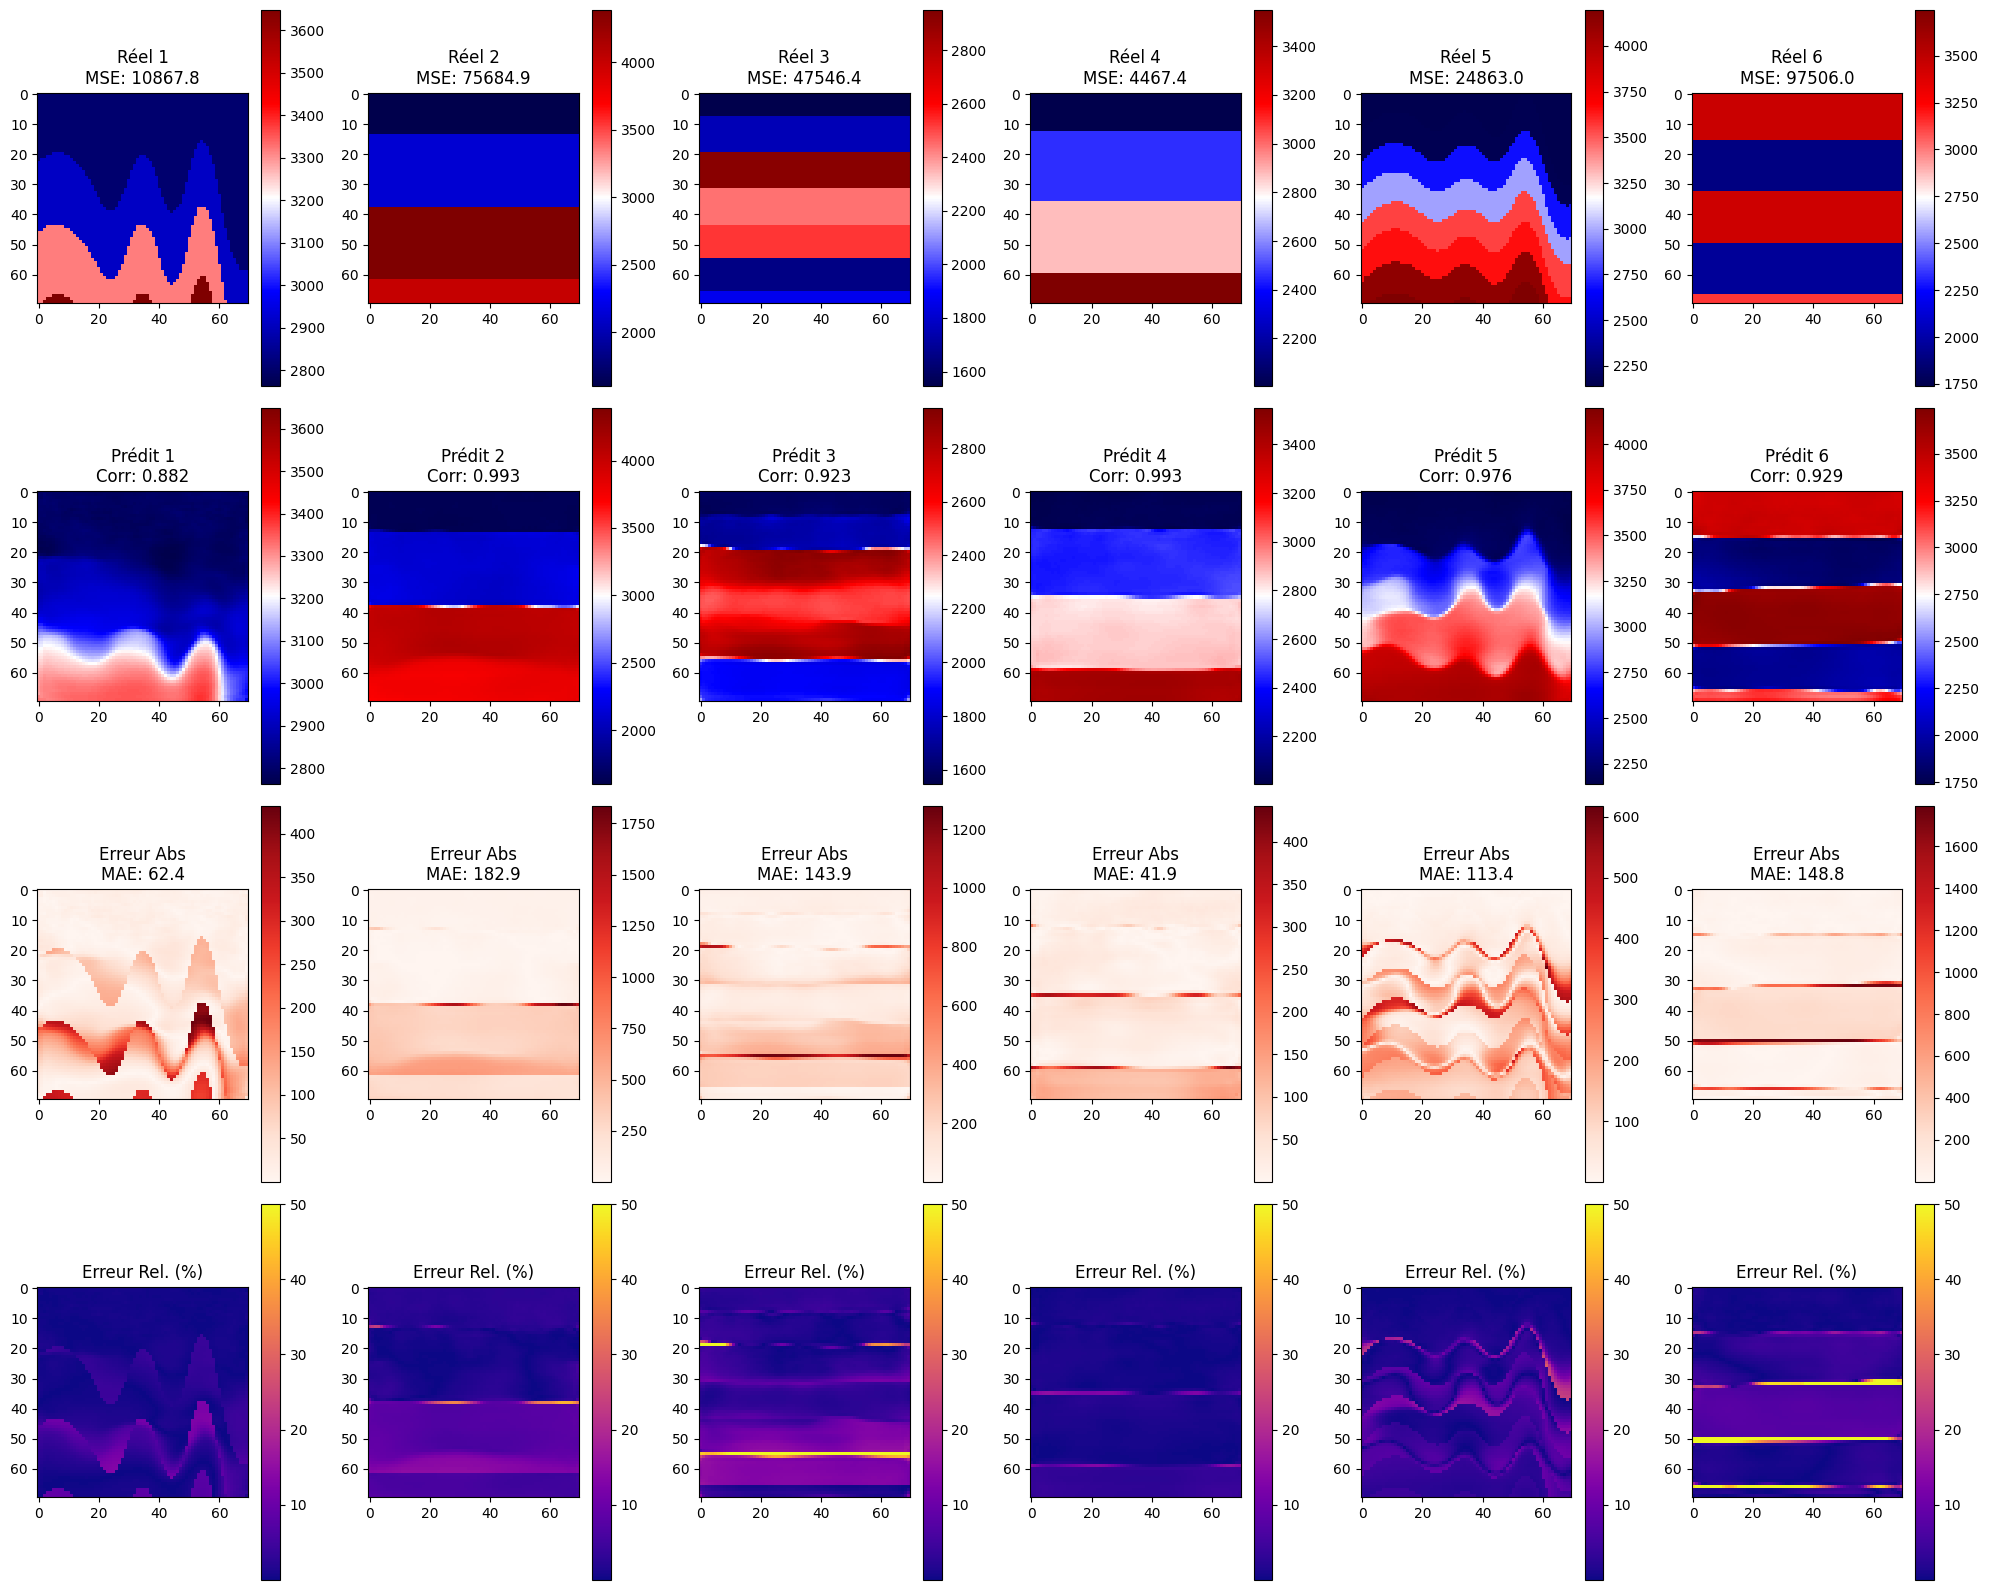


MÉTRIQUES FINALES (Dénormalisées)
MSE moyen: 43489.24 ± 33923.04
MAE moyen: 115.54 ± 49.51
Corrélation moyenne: 0.9494 ± 0.0413


In [27]:
# 11. Évaluation sophistiquée
model.eval()
with torch.no_grad():
    test_indices = [0, 1, 2, 3, 10, 15]  # Plus d'échantillons de test
    
    fig, axes = plt.subplots(4, len(test_indices), figsize=(20, 16))
    
    mse_scores = []
    mae_scores = []
    correlation_scores = []
    
    for i, idx in enumerate(test_indices):
        if idx >= len(val_dataset):
            continue
            
        x_test, y_test = val_dataset[idx]
        x_test = x_test.unsqueeze(0).to(device)
        pred = model(x_test).squeeze(0).cpu()
        
        # Dénormalisation
        y_test_denorm = y_test[0] * saved_y_std + saved_y_mean
        pred_denorm = pred[0] * saved_y_std + saved_y_mean
        
        # Métriques
        mse = mean_squared_error(y_test_denorm.flatten(), pred_denorm.flatten())
        mae = mean_absolute_error(y_test_denorm.flatten(), pred_denorm.flatten())
        correlation = np.corrcoef(y_test_denorm.flatten(), pred_denorm.flatten())[0,1]
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        correlation_scores.append(correlation)
        
        # Visualisation
        vmin = min(y_test_denorm.min(), pred_denorm.min())
        vmax = max(y_test_denorm.max(), pred_denorm.max())
        
        # Vitesse réelle
        im1 = axes[0, i].imshow(y_test_denorm, cmap='seismic', vmin=vmin, vmax=vmax)
        axes[0, i].set_title(f'Réel {i+1}\nMSE: {mse:.1f}')
        plt.colorbar(im1, ax=axes[0, i])
        
        # Vitesse prédite
        im2 = axes[1, i].imshow(pred_denorm, cmap='seismic', vmin=vmin, vmax=vmax)
        axes[1, i].set_title(f'Prédit {i+1}\nCorr: {correlation:.3f}')
        plt.colorbar(im2, ax=axes[1, i])
        
        # Erreur absolue
        error = np.abs(y_test_denorm - pred_denorm)
        im3 = axes[2, i].imshow(error, cmap='Reds')
        axes[2, i].set_title(f'Erreur Abs\nMAE: {mae:.1f}')
        plt.colorbar(im3, ax=axes[2, i])
        
        # Erreur relative
        rel_error = np.abs(error / (np.abs(y_test_denorm) + 1e-8)) * 100
        im4 = axes[3, i].imshow(rel_error, cmap='plasma', vmax=50)
        axes[3, i].set_title(f'Erreur Rel. (%)')
        plt.colorbar(im4, ax=axes[3, i])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"MÉTRIQUES FINALES (Dénormalisées)")
    print(f"{'='*60}")
    print(f"MSE moyen: {np.mean(mse_scores):.2f} ± {np.std(mse_scores):.2f}")
    print(f"MAE moyen: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
    print(f"Corrélation moyenne: {np.mean(correlation_scores):.4f} ± {np.std(correlation_scores):.4f}")
    print(f"{'='*60}")

Évaluation du modèle : analyse visuelle et métrique

Le modèle **SeismicUNet** a été évalué sur un échantillon de 6 exemples issus du jeu de validation. Chaque exemple est représenté par :

1. **Carte de vitesse réelle** (ligne 1)
2. **Carte prédite par le modèle** (ligne 2)
3. **Erreur absolue** (ligne 3)
4. **Erreur relative en %** (ligne 4)

Interprétation qualitative des résultats

- Les cartes prédites reproduisent fidèlement les grandes structures du sous-sol, même dans les cas complexes (échantillons 1, 3 et 5).
- Les erreurs absolues restent modérées dans les zones structurées, sauf pour les échantillons à couches abruptes (ex : 2 et 6), probablement dues à des discontinuités difficiles à apprendre.
- Les erreurs relatives sont majoritairement **inférieures à 20 %**, sauf dans les interfaces ou les zones peu informées.

Résultats quantitatifs globaux (valeurs dénormalisées)

| Métrique                | Moyenne   | Écart-type |
|-------------------------|-----------|------------|
| **MSE (m/s²)**          | 43 489    | ± 33 923   |
| **MAE (m/s)**           | 115.5     | ± 49.5     |
| **Corrélation Pearson** | 0.9494    | ± 0.0413   |

> Ces scores traduisent une excellente capacité de généralisation du modèle, avec une erreur moyenne inférieure à **120 m/s**, soit environ **4 %** de la vitesse moyenne (~2850 m/s).

 **Conclusion** : Le modèle reproduit efficacement les caractéristiques sismiques complexes et peut être envisagé pour des tâches d'inversion temps-réel ou comme outil de pré-analyse avant l’inversion physique complète.

---

# Analyse des courbes d'apprentissage

Nous analysons ici l’évolution des pertes au cours de l’entraînement.

# Graphe 1 : Perte globale
- Compare la **perte d'entraînement** et la **perte de validation** pour évaluer la convergence et détecter un éventuel surapprentissage.
- Une bonne courbe montre une diminution progressive, avec un écart modéré entre train et val.

# Graphes 2 à 4 : Composantes de la perte
Nous avons utilisé une **fonction de perte composite**, composée de :
- **MSE (erreur quadratique moyenne)** : capture les grandes erreurs,
- **L1 (erreur absolue)** : encourage des prédictions stables,
- **SSIM** : mesure la similarité structurelle entre les images,
- **Gradient Loss** : pénalise les erreurs sur les discontinuités.

> Ces graphiques permettent d’observer l’équilibre entre les composantes et de comprendre quelles caractéristiques le modèle apprend en priorité (structure, régularité, transitions, etc.).

Ensemble, ces courbes fournissent une vue complète de la dynamique d'apprentissage.


IndexError: index 2 is out of bounds for axis 0 with size 2

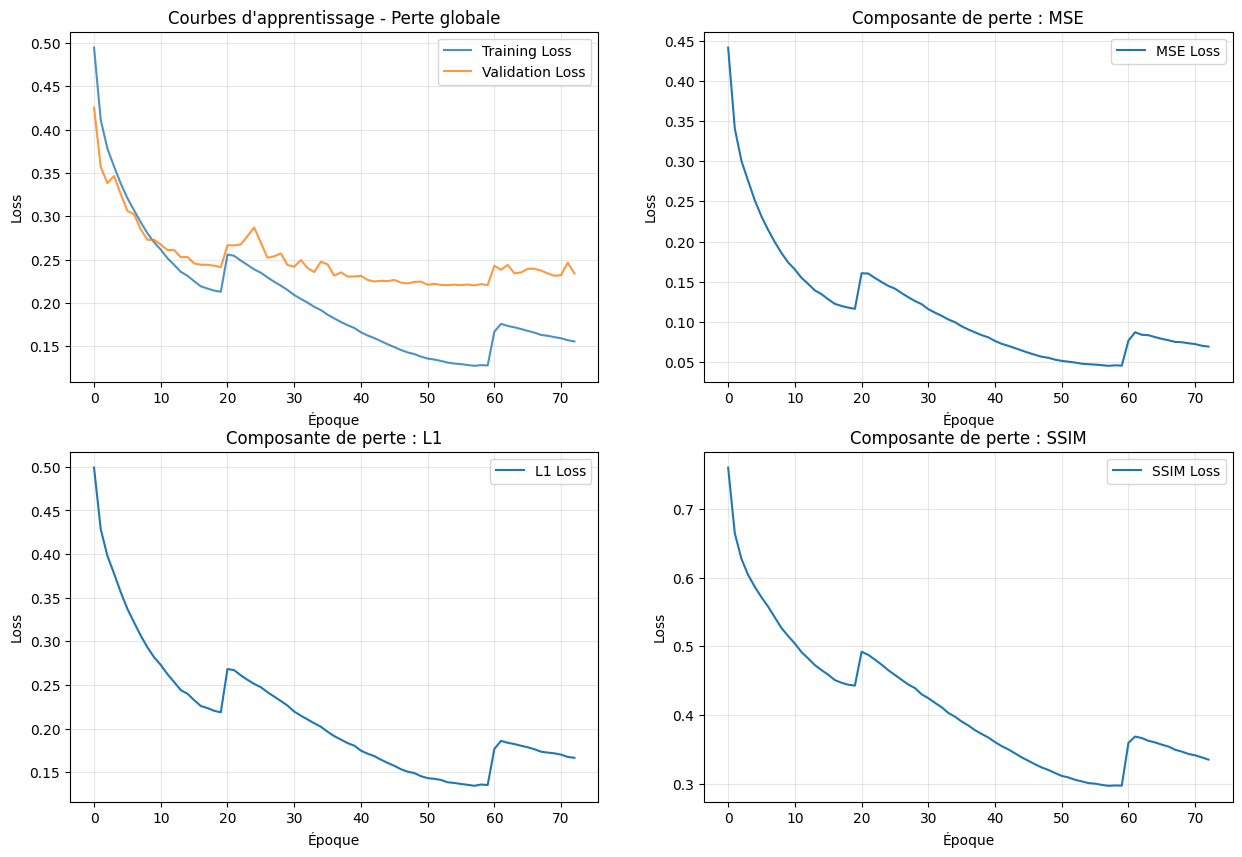

In [28]:
# 12. Analyse des courbes d'apprentissage
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Perte globale (train vs val)
axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.8)
axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.8)
axes[0, 0].set_xlabel('Époque')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Courbes d\'apprentissage - Perte globale')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Affichage des composantes de perte (MSE, L1, SSIM, Grad)
for i, (key, values) in enumerate(loss_components.items()):
    row = (i + 1) // 2  # commence à 0 -> (1,2)->0, (3,4)->1
    col = (i + 1) % 2
    axes[row, col].plot(values, label=f'{key.upper()} Loss')
    axes[row, col].set_xlabel('Époque')
    axes[row, col].set_ylabel('Loss')
    axes[row, col].set_title(f'Composante de perte : {key.upper()}')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Entraînement terminé! Le modèle U-Net avancé est prêt.")

Analyse des courbes d'apprentissage

L'évolution des différentes pertes montre que l'entraînement du modèle s’est déroulé de manière stable et efficace :

Perte globale (train vs validation)

- La **perte d'entraînement** diminue régulièrement jusqu'à environ l’époque 55.
- La **perte de validation** suit globalement la même tendance avec un léger plateau autour de l’époque 20, indiquant un début de stabilisation.
- Après l’époque 60, une légère remontée de la perte de validation justifie le déclenchement du **early stopping** à l’époque 73, évitant ainsi le sur-apprentissage.

Analyse des composantes de la fonction de perte

- **MSE Loss** : chute rapide en début d’entraînement, puis stabilisation, preuve d’une réduction de l’erreur quadratique sur les vitesses prédites.
- **L1 Loss** : suit une trajectoire similaire, ce qui confirme que les valeurs prédites sont de plus en plus proches des valeurs réelles en moyenne.
- **SSIM Loss** : baisse plus lente, mais régulière, indiquant une amélioration continue de la **structure spatiale** dans les cartes prédites (préservation des couches).
- **Gradient Loss** (non affichée ici) : elle contribue à la préservation des **discontinuités géologiques** dans la prédiction, essentielle pour la cohérence géophysique.


Ces courbes indiquent que l’apprentissage est **convergent**, que la perte est bien équilibrée, et que le modèle ne présente pas de sur-ajustement excessif. L’utilisation combinée des métriques (MSE, L1, SSIM, Gradient) permet d’obtenir des prédictions **visuellement et physiquement cohérentes**.

---

# Conclusion du projet

Dans ce projet, nous avons implémenté une architecture U-Net avancée pour résoudre un problème d’**inversion sismique** à partir de données synthétiques. L’objectif était de prédire des **cartes de vitesse du sous-sol** à partir de volumes sismiques multi-canaux.

**Points forts de l’approche** :

- **Prétraitement robuste** incluant redimensionnement bilinéaire, normalisation par canal et clipping statistique.
- **Modèle U-Net profond** enrichi par des **modules d’attention** spatiale et canal, afin d’améliorer la localisation des discontinuités et la cohérence des structures.
- **Fonction de perte multi-composantes** combinant MSE, L1, SSIM et gradient loss, pour optimiser à la fois la fidélité numérique et la géométrie structurale.
- **Stratégies d’entraînement avancées** avec scheduler dynamique, early stopping et clipping des gradients.

**Résultats obtenus** :

- **MSE moyen** : 43 489 ± 33 923  
- **MAE moyen** : 115.5 ± 49.5  
- **Corrélation moyenne** : 0.949 ± 0.041  
Ces résultats traduisent une **précision élevée** dans la prédiction des vitesses, avec une **forte corrélation** avec le terrain réel simulé.

**Perspectives et améliorations possibles** :

- Intégration de **bruits réels** pour augmenter la robustesse.
- Entraînement sur un **volume plus grand** ou sur des cas réels d’exploration géologique.
- Ajout de **contraintes physiques explicites** dans l’apprentissage (e.g. ondes réfléchies, régularisation par équations différentielles).


**En résumé**, ce projet démontre qu’une combinaison intelligente de deep learning, de géophysique et de techniques avancées d’optimisation permet de s’approcher d’une inversion sismique efficace et automatisée.

---

# Partie: Soumission Sur Kaggle 

In [ ]:
# --- 1. Charger les données test ---
test_dir = '/kaggle/input/waveform-inversion/test'
test_files = sorted([os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.npy')])

test_data_list = []
for f in test_files:
    data = np.load(f)  # (500, 5, 1000, 70)
    test_data_list.append(data)

test_data = np.concatenate(test_data_list, axis=0)  # (N, 5, 1000, 70)
print(f"Test data shape before downsampling: {test_data.shape}")

In [ ]:
# --- 2. Downsampling identique au modèle ---
def downsample_to_70(arr):
    tensor = torch.tensor(arr, dtype=torch.float32)
    tensor = tensor.permute(0, 1, 3, 2)  # (N, 5, 70, 1000)
    tensor = F.interpolate(tensor, size=(70, 70), mode='bilinear', align_corners=False)
    tensor = tensor.permute(0, 1, 3, 2)  # (N, 5, 70, 70)
    return tensor.numpy()

test_data_ds = downsample_to_70(test_data)
print(f"Test data shape after downsampling: {test_data_ds.shape}")  # (N, 5, 70, 70)

In [ ]:
# --- 4. Inférence avec le modèle chargé ---
model.eval()
predictions = []
with torch.no_grad():
    for xb in test_loader:
        xb = xb.to(device)
        out = model(xb)  # (B, 1, 70, 70)
        out = out.squeeze(1).cpu().numpy()  # (B, 70, 70)
        predictions.append(out)

predictions = np.concatenate(predictions, axis=0)
print(f"Nombre de fichiers test: {len(test_files)}")
print(f"Nombre de prédictions: {predictions.shape[0]}")

In [ ]:
# --- 5. Garder colonnes impaires uniquement ---
predictions = predictions[:, :, 1::2]  # (N_pred, 70, 35)

In [ ]:
# --- 6. Construction du DataFrame de soumission ---
rows = []
max_samples = min(len(test_files), predictions.shape[0])
for i in range(max_samples):
    base_name = os.path.basename(test_files[i]).replace('.npy', '')
    pred = predictions[i]
    for y in range(pred.shape[0]):
        oid_ypos = f"{base_name}_y_{y}"
        row = [oid_ypos] + pred[y].tolist()
        rows.append(row)

cols = ['oid_ypos'] + [f'x_{x}' for x in range(1, 70, 2)]
submission_df = pd.DataFrame(rows, columns=cols)

In [ ]:
# --- 7. Sauvegarde ---
submission_df.to_csv('submission.csv', index=False)
print("Fichier submission.csv généré avec succès.")
